<a href="https://colab.research.google.com/github/AlexandraVallet/fenicslectures/blob/main/Solution_Braindiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion in the brain

Analysis of the Paper : 

Sleep deprivation impairs molecular clearance from the human brain,
Per Kristian Eide, Vegard Vinje, Are Hugo Pripp, Kent-Andre Mardal, Geir Ringstad,
Brain, Volume 144, Issue 3, March 2021, Pages 863–874, https://doi.org/10.1093/brain/awaa443

![image.png](https://github.com/AlexandraVallet/fenicslectures/blob/main/images/brain_enrichment.png?raw=1)



# Diffusion equation 

We consider the diffusion of the concentration c of a chemical solute (here the Gadobustrol tracer), as a function of the position x. 
Experimentally it is known that the flux of this quantity, ie the amount of the quantify crossing a unit area per time, is given by the relation
$$ F = - k \nabla c $$ with k the diffusivity. 
We note hee the minus sign, as the diffusion flux is directed toward the regions of lower concentration. 

The diffusion equation for the concentration is then given by 
$$\frac{\partial c}{\partial t}= - k \Delta c + S(x) $$
where $S(x)$ is a source term.

# Steady state

In the case of a steady problem, the problem become a Laplace problem : 

\begin{alignat}{2}
-\Delta c &= f \quad && \text{ in } \Omega \\
u &= u_{\mathrm{D}} \quad && \text{ on } \Gamma_{\mathrm{D}} \\
\partial_n u &= g \quad && \text{ on } \Gamma_{\mathrm{N}}
\end{alignat}

with $f=S(x)/k$, $u_{\mathrm{D}}$ is the dirichlet boundary condition and $ g$ is a Neumann boundary condition.

Let's try to resolve this equation using FEniCS !


# Solve the problem with FEniCS 

For hints and more reading on how to solve the Poisson problem in FEniCS, see the [section on the Poisson problem](https://fenicsproject.org/pub/tutorial/html/._ftut1004.html#ch:fundamentals) in the [FEniCS Tutorial](https://fenicsproject.org/tutorial/).

## Importing FEniCS
The first thing we need to do is to import FEniCS. We will also need to import the meshing library `mshr`.

In [2]:
# Installing and Importing Fenics
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics



E: Package 'python-software-properties' has no installation candidate
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:8 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/fenics-packages/fenics/ubuntu bionic InRelease
Hit:14 ht

In [2]:
try:
    import google.colab  # noqa: F401
except ImportError:
    import dolfin
    import mshr
else:
    try:
        import dolfin
        import mshr
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
        import dolfin
        import mshr

## Initializing notebook plotting
When running in a Jupyter notebook, a special line is necessary to show FEniCS plots in the notebook.

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 

## Importing other libraries



In [24]:
import numpy as np
from math import sqrt

## Creating the mesh

Let create a mesh for square domain with a circular hole in the middle.

To create the mesh, we use boolean operators (CSG = Constructive Solid Geometry) from `mshr`. 

Define one square and a circle, then combine them with operators `+` (union), `*` (intersection) or `-` (set difference). 

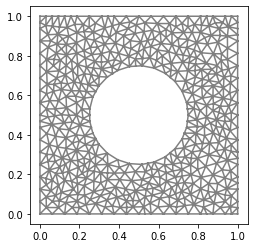

In [12]:
S0 = mshr.Rectangle(dolfin.Point(0, 0), dolfin.Point(1, 1))
C0 = mshr.Circle(dolfin.Point(0.5,0.5),0.25)
domain = S0-C0
mesh = mshr.generate_mesh(domain,20)
dolfin.plot(mesh)

## Defining the finite element function space
Once the mesh is created, we can define the finite element function space. We will use a standard piecewise linear $P_1$ function space.

In [13]:
V = dolfin.FunctionSpace(mesh,'P',1)

Calling FFC just-in-time (JIT) compiler, this may take some time.


## Defining the boundary condition
The boundaries can be defines using a condition of distance. 

The inner boundary in the inner circle can be defined using the distance to the circle center.

In [30]:
def circle(x, on_boundary):
    # distance to the center of the circle
    #x being the coordiate in two dimensions : x[0] and x[1]
    d0 = sqrt((x[0]-0.5)**2 + (x[1]-0.5)**2)
    # let chose a tolerance distance 
    tol = 0.05
    # radius of the circle
    r=0.25
    #condition to be on the circle (of radius 0.25)
    return on_boundary and (d0 < r+tol)



The outer boundary 


In [107]:
def outside(x, on_boundary):
    # distance to the center of the circle
    #x being the coordiate in two dimensions : x[0] and x[1]
    d0 = sqrt((x[0]-0.5)**2 + (x[1]-0.5)**2)
    r=0.5
    #condition to be on the circle (of radius 0.25)
    return on_boundary and (d0 > r)

The Dirichlet boundary condition 

$$ u = u_{\mathrm{D}} \quad  \text{ on } \Gamma_{\mathrm{D}} $$

are defined using a dolfin function.

We decide to impose c=0 on the inner circle boundary

In [31]:
bc = dolfin.DirichletBC(V, 0 , circle)

The neuman boundary conditions 

$$\partial_n u = g \quad  \text{ on } \Gamma_{\mathrm{N}} $$

will appear directly in the weak form of the equations.

## Defining the variational problem
The finite element variational problem for the Poisson equation reads: 

Find $u \in V$ such that
$$
-\int_{\Omega} (\nabla^2 u)  v \,\mathrm{d}x = \int_{\Omega} fv \,\mathrm{d}x 
$$


We have 
$$
-\int_{\Omega} (\nabla^2 u)  v \,\mathrm{d}x =\int_{\Omega} \nabla u \cdot \nabla v \,\mathrm{d}x - \int_{\partial \Omega} \frac{\partial u}{\partial n} v  \,\mathrm{d}s
$$


By definition of the finite element function space $v=0$ on $\Gamma_D$, thus

$$ - \int_{\partial \Omega} \frac{\partial u}{\partial n} v  \,\mathrm{d}s = - \int_{\partial\Omega} gv \,\mathrm{d}s $$

he resulting weak form of our problem reads


$$
\int_{\Omega} \nabla u \cdot \nabla v \,\mathrm{d}x = \int_{\Omega} fv \,\mathrm{d}x +\int_{\partial\Omega} gv \,\mathrm{d}s
$$
for all $v \in V$.

This can be expressed in FEniCS by defining the *bilinear form* $a$ and the *linear form* $L$:

\begin{align}
  a(u, v) &= \int_{\Omega} \nabla u \cdot \nabla v \,\mathrm{d}x, \\
  L(v) &= \int_{\Omega} fv \,\mathrm{d}x+\int_{\partial\Omega} gv \,\mathrm{d}s.
\end{align}

And the problem is to solve 

$$a(u, v)= L(v)$$ 

We first define the trial and test function using the built in functions

In [108]:
u = dolfin.TrialFunction(V)
v = dolfin.TestFunction(V)


Then let define the source term as a gaussian function

In [129]:
f = dolfin.Expression('exp(-10.0*(pow(x[0]-0.5,2) + pow(x[1] - 0.5,2)))',degree = 2)

We define an outer flow boundary condition on the outer edge:


In [126]:
g=dolfin.Constant(1)

The bilinear form a and the linea form L are defined as follow :**bold text**

In [127]:
a = dolfin.inner(dolfin.grad(u), dolfin.grad(v))*dolfin.dx
L = f*v*dolfin.dx + g*v*dolfin.ds

The ds variable implies a boundary integral, while dx implies an integral over the domain Ω

Note that the integration *ds is carried out over the entire boundary, including the Dirichlet boundary. However, since the test function v vanishes on the Dirichlet boundary (as a result specifying a DirichletBC), the integral will only include the contribution from the Neumann boundary.

## Solving the variational problem
The variational problem can now be solved by calling the FEniCS `solve` command. Use the `plot` command to visualize the solution. 

Calling FFC just-in-time (JIT) compiler, this may take some time.


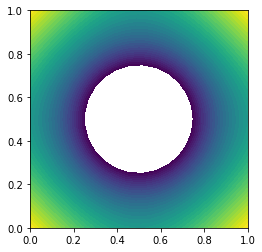

In [128]:
c = dolfin.Function(V)
dolfin.solve(a == L, c, bc)
dolfin.plot(c)

## Postprocessing

We can integrate the value of c over the entire domain.

In [32]:
integral=dolfin.assemble(c*dolfin.dx(mesh))

print('Total mass :',integral)

Total mass : 0.005722636823599106


# Time dependant solution

We now consider the time dependant problem governed by the diffusion equation 

$$\frac{\partial c}{\partial t}= -k\Delta c + S(x)$$

## Time discretisation 

We discretize the time derivative with a finite difference approximation.


Let superscript $n$ denote a quantity at time $t_n$, where $n$ is an integer counting the time steps of length $\Delta t$. The time derivative can be discretized by

$$ \frac{\partial c}{\partial t}^{n+1}= \frac{c^{n+1}-c^{n}}{\Delta t}$$

Then, using an implicit backward Euler scheme, the diffusion equation at time step $n+1$ is

$$ \frac{c^{n+1}-c^{n}}{\Delta t}=-k\Delta c^{n+1} + S(x)^{n+1}$$

The solution of c at time step $n+1$ is obtained by solving a stationary problem 

$$ c^{n+1}+k\Delta c^{n+1} \Delta t - S(x)^{n+1} \Delta t - c^n =0$$


## Variational form 

Let u be the solution $c^{n+1}$. 



We multiply by a test function v and integrate second-derivatives by parts and use the divergence theorem. This lead to the bilinear and linear forms

\begin{align}
  a(u, v) &= \int_{\Omega} (uv + k\Delta t \nabla u \cdot \nabla v ) \,\mathrm{d}x, \\
  L(v) &= \int_{\Omega}  (S(x)^{n+1} \Delta t + c^{n} ) v  \,\mathrm{d}x+\int_{\partial \Omega} g^{n+1}\Delta t v \,\mathrm{d}s
\end{align}





In [131]:
# for the exemple we set a time step 
dt=1
# a uniform previous solution at previous time step
u_n=dolfin.interpolate(dolfin.Constant(0),V)
# a uniform source term
S=dolfin.interpolate(dolfin.Constant(0),V)
# a diffusion coefficient
k=1


F = u*v*dolfin.dx + k*dt*dolfin.inner(dolfin.grad(u), dolfin.grad(v))*dolfin.dx - (u_n + dt*S)*v*dolfin.dx + dt*g*v*dolfin.ds
a, L = dolfin.lhs(F), dolfin.rhs(F)

## Initial conditions

Let define the initial conditions. 

For example, as the tracer enter the brain from the outer surface, we use the gaussian function to initialise a concentration close to zero in the center of the circle and close to one at the boudaries. 


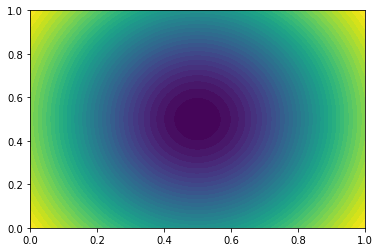

In [41]:
x=np.linspace(0,1,100) 
y=np.linspace(0,1,100)

X,Y =np.meshgrid(x, y)

x0=0.5 
y0=0.5 
sx=0.5 
sy=0.5
A=1

Z=A-A*np.exp(-((X-x0)**2/(2*sx**2) + (Y - y0)**2)/(2*sy**2))

plt.contourf(X,Y,Z,50)


In [105]:
cinit=dolfin.Expression('A-A*exp(-((pow(x[0]-x0,2)/(2*pow(sx,2)))+(pow(x[1]-y0,2)/(2*pow(sy,2)))))', A=1,x0=0.5,y0=0.5,sx=0.5,sy=0.5,degree = 2)

Interpolate the initial function on the finite element space

In [68]:
u_n = dolfin.interpolate(cinit, V)

## Source term definition

We set the source term as a homogeneous sink term. 





In [69]:
S=dolfin.Constant(1)

## Resolution 

Finaly we solve the problem over several time steps



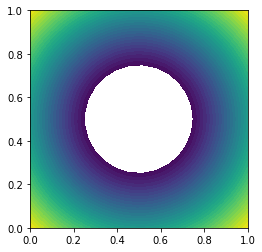

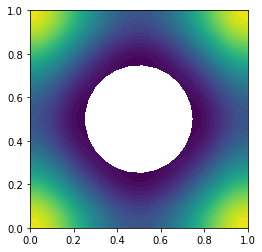

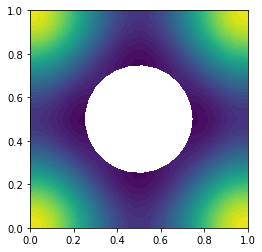

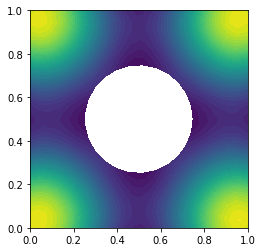

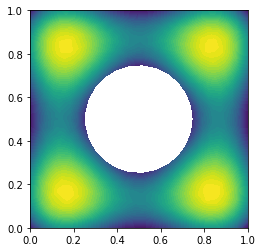

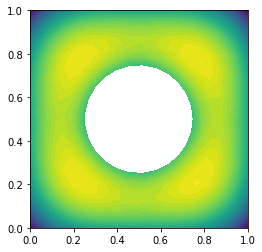

In [135]:
t = 0
num_steps=5

dt=0.1

u = dolfin.TrialFunction(V)
v = dolfin.TestFunction(V)

k=1

u_n = dolfin.interpolate(cinit, V)

plt.figure()
dolfin.plot(u_n)


S=-dolfin.Constant(0.0001)
g=dolfin.Constant(0.001)


# We update with new initial solution and sink term
F = u*v*dolfin.dx + k*dt*dolfin.inner(dolfin.grad(u), dolfin.grad(v))*dolfin.dx - (u_n + dt*S)*v*dolfin.dx+ dt*g*v*dolfin.ds
a, L = dolfin.lhs(F), dolfin.rhs(F)

u = dolfin.Function(V)


# Create a list to store the value of the total mass
mass=dolfin.assemble(u_n*dolfin.dx(mesh))
spanmass=[mass]

for n in range(num_steps):

    # Update current time
    t += dt
    # Solve variational problem
    dolfin.solve(a == L, u,bc)

    # Update previous solution
    u_n.assign(u)

    #add the mass to the list
    mass=dolfin.assemble(u_n*dolfin.dx(mesh))
    spanmass.append(mass)

    plt.figure()
    dolfin.plot(u)


Text(0.5, 0, 'Time')

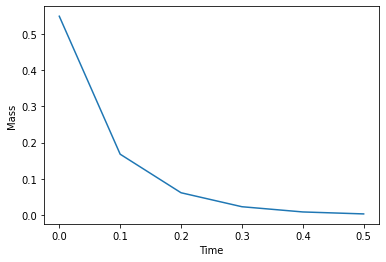

In [102]:
spantime=np.linspace(0,dt*num_steps,num_steps+1)
plt.plot(spantime,spanmass)
plt.ylabel('Mass')
plt.xlabel('Time')

# Simulation of the Gadobustrol experiments

Let set the mesh and the parameters of the problem to represent the Gadobustrol experiment. 

- Typical size of the brain : 15 cm
- Gadobustrol apparent diffusion coefficient : 1.5 × 10−5 cm2/s


## Enrichment phase

Assuming the concentration is 100 in the subarachnoid space after injection. What is the profile of concentration in the brain after 6 hours ?


## Clearance phase

From the previous concentration profile, we would like to compute the clearance. Clearance can be homogeneous over the whoe brain (throught capillaries) or done only from the outersurface. It is driven by the reabsoption of cerebrospinal fluid :

- The total CSF turn-over rate has been estimated to 500 ml/day in humans

Can you simulate the clearance phase ? 

How does the diffusion coefficient impact this clearance ? Can we make the assumption that this coefficient is different during sleep and awake phases ?


Note : We recomand to work in the CGS unit system (cm, gram, second)

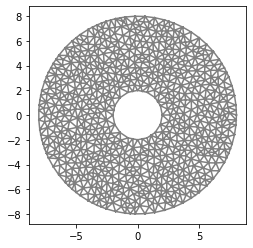

In [154]:
S0 = mshr.Circle(dolfin.Point(0.,0.),8)
C0 = mshr.Circle(dolfin.Point(0.,0.),2)
domain = S0-C0
mesh = mshr.generate_mesh(domain,20)
dolfin.plot(mesh)

In [143]:
def inner(x, on_boundary):
    # distance to the center of the circle
    #x being the coordiate in two dimensions : x[0] and x[1]
    d0 = sqrt((x[0]-0)**2 + (x[1]-0)**2)
    # let chose a tolerance distance 
    tol = 0.1
    # radius of the circle
    r=2
    #condition to be on the circle (of radius 0.25)
    return on_boundary and (d0 < r+tol)


def outter(x, on_boundary):
    # distance to the center of the circle
    #x being the coordiate in two dimensions : x[0] and x[1]
    d0 = sqrt((x[0]-0)**2 + (x[1]-0)**2)
    r=5
    #condition to be on the circle (of radius 0.25)
    return on_boundary and (d0 > r)

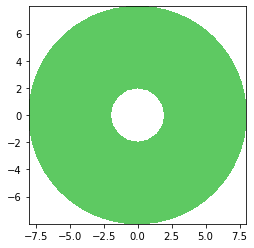

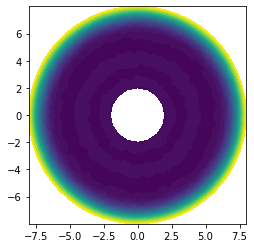

In [204]:
t = 0

tend=60*60*6 # seconds

num_steps=100

dt=tend/num_steps

V = dolfin.FunctionSpace(mesh,'P',1)


k=1.5e-5 #cm2/s


u_n = dolfin.interpolate(dolfin.Constant(0), V)

plt.figure()
dolfin.plot(u_n)


# Dirichlet boundary condition on the outer side
bc = dolfin.DirichletBC(V, dolfin.Constant(1) , outter)



# Create a list to store the value of the total mass
mass=dolfin.assemble(u_n*dolfin.dx(mesh))
spanmass=[mass]
spantime=[t]

for n in range(num_steps):

    # Update current time
    t += dt
   
    # update system of equations
    u = dolfin.TrialFunction(V)
    v = dolfin.TestFunction(V)
    S=-dolfin.Constant(0) # uniform source term
    g=dolfin.Constant(0) # flow condition on Neumann boundaries
    # We update with new initial solution and sink term
    F = u*v*dolfin.dx + k*dt*dolfin.inner(dolfin.grad(u), dolfin.grad(v))*dolfin.dx - (u_n + dt*S)*v*dolfin.dx+ dt*g*v*dolfin.ds
    a, L = dolfin.lhs(F), dolfin.rhs(F)


    # Solve variational problem
    u = dolfin.Function(V)
    dolfin.solve(a == L, u,bc)

    # Update previous solution
    u_n.assign(u)

    #add the mass to the list
    mass=dolfin.assemble(u_n*dolfin.dx(mesh))
    spanmass.append(mass)
    spantime.append(t)


# plot the final concentration profile
plt.figure()
dolfin.plot(u)

Text(0.5, 0, 'Time (h)')

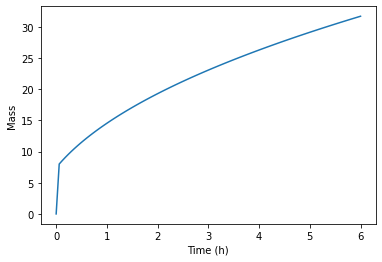

In [196]:
plt.plot(np.array(spantime)/60/60,spanmass)
plt.ylabel('Mass')
plt.xlabel('Time (h)')

In [197]:
u6h=dolfin.interpolate(u_n, V)
t6h=tend
spantime6h=spantime
spanmass6h=spanmass

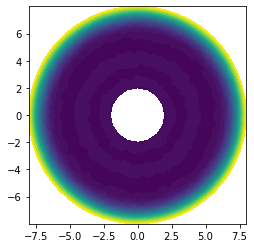

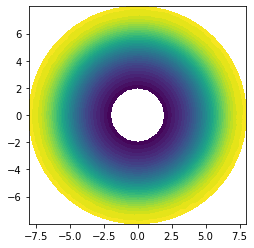

In [225]:
t = t6h

tend=60*60*48 # seconds

num_steps=100

dt=(tend-t)/num_steps


k=1.5e-5 #cm2/s

V = dolfin.FunctionSpace(mesh,'P',1)


u_n = dolfin.interpolate(u6h, V)

plt.figure()
dolfin.plot(u_n)

brainvol=4/3*3.14*8**3-4/3*3.14*2**3
brainsurf=4*3.14*8**2

QCSF=500/(60*60*24)


# Dirichlet boundary condition on the inner side
bc = dolfin.DirichletBC(V, dolfin.Constant(0) , inner)



# Create a list to store the value of the total mass
mass=dolfin.assemble(u_n*dolfin.dx(mesh))
spanmass=[mass]
spantime=[t]

for n in range(num_steps):

    # Update current time
    t += dt

    # update system of equations
    u = dolfin.TrialFunction(V)
    v = dolfin.TestFunction(V)

    # option 1
    S=-u_n*QCSF/brainvol*4#  source term
    g=dolfin.Constant(0) # flow condition on Neumann boundaries


    # We update with new initial solution and sink term
    F = u*v*dolfin.dx + k*dt*dolfin.inner(dolfin.grad(u), dolfin.grad(v))*dolfin.dx - (u_n + dt*S)*v*dolfin.dx+ dt*g*v*dolfin.ds
    a, L = dolfin.lhs(F), dolfin.rhs(F)


    # Solve variational problem
    u = dolfin.Function(V)
    dolfin.solve(a == L, u,bc)

    # Update previous solution
    u_n.assign(u)

    #add the mass to the list
    mass=dolfin.assemble(u_n*dolfin.dx(mesh))
    spanmass.append(mass)
    spantime.append(t)


# plot the final concentration profile
plt.figure()
dolfin.plot(u)

In [226]:
#save results
spanmassk0=spanmass

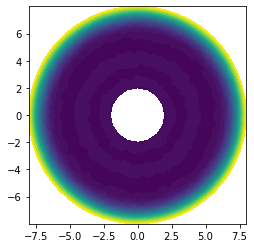

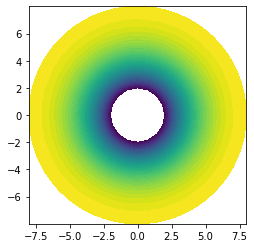

In [231]:
# change permeability 

t = t6h

k=1.5e-5*10 #cm2/s

V = dolfin.FunctionSpace(mesh,'P',1)


u_n = dolfin.interpolate(u6h, V)

plt.figure()
dolfin.plot(u_n)

brainvol=4/3*3.14*8**3-4/3*3.14*2**3
brainsurf=4*3.14*8**2

QCSF=500/(60*60*24)


# Dirichlet boundary condition on the inner side
bc = dolfin.DirichletBC(V, dolfin.Constant(0) , inner)



# Create a list to store the value of the total mass
mass=dolfin.assemble(u_n*dolfin.dx(mesh))
spanmass=[mass]
spantime=[t]

for n in range(num_steps):

    # Update current time
    t += dt

    # update system of equations
    u = dolfin.TrialFunction(V)
    v = dolfin.TestFunction(V)

    # option 1
    S=-u_n*QCSF/brainvol*4#  source term
    g=dolfin.Constant(0) # flow condition on Neumann boundaries


    # We update with new initial solution and sink term
    F = u*v*dolfin.dx + k*dt*dolfin.inner(dolfin.grad(u), dolfin.grad(v))*dolfin.dx - (u_n + dt*S)*v*dolfin.dx+ dt*g*v*dolfin.ds
    a, L = dolfin.lhs(F), dolfin.rhs(F)


    # Solve variational problem
    u = dolfin.Function(V)
    dolfin.solve(a == L, u,bc)

    # Update previous solution
    u_n.assign(u)

    #add the mass to the list
    mass=dolfin.assemble(u_n*dolfin.dx(mesh))
    spanmass.append(mass)
    spantime.append(t)


# plot the final concentration profile
plt.figure()
dolfin.plot(u)

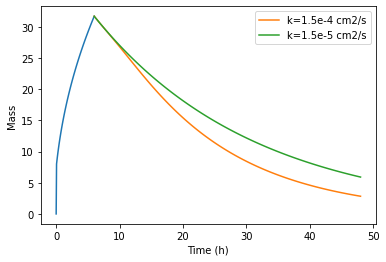

In [233]:
# compare the two simulations
plt.plot(np.array(spantime6h)/60/60,spanmass6h)
plt.plot(np.array(spantime)/60/60,spanmass, label='k=1.5e-4 cm2/s')
plt.plot(np.array(spantime)/60/60,spanmassk0, label='k=1.5e-5 cm2/s')
plt.ylabel('Mass')
plt.xlabel('Time (h)')
plt.legend()